Был выбран CycleGAN.
Вначале реализуется своя архитектура на известной задаче яблоки/апельсины.

In [1]:
pip install tensorboardX

     |████████████████████████████████| 317kB 16.1MB/s 


In [2]:
pip install visdom

     |████████████████████████████████| 686kB 15.1MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp37-none-any.whl size=655251 sha256=26b260f8d5cd1568ff827e295fd6b8bf1d13b3cf49f3f6dcdaa37932f2587a28
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5713 sha256=0b1ae8b44e02bf60b314d7fe6dd9feb7ec5f42328060faf1ff6ad95c66299dfd
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import os
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import random
import time
import datetime
import sys
from torch.autograd import Variable
from visdom import Visdom
import itertools
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import glob
from torch.utils.data import Dataset
from IPython.display import clear_output

In [4]:
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from multiprocessing.pool import ThreadPool
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


In [5]:
class G_generator(nn.Module):  #в качестве генератора использован юнет, что дает более четкий результат на сгенерированных картинках
      def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size = 3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
        )
        self.pool0 =  nn.MaxPool2d(kernel_size = 2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size = 3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
        )
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
        )

        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
           
        )
        self.pool3 =  nn.MaxPool2d(kernel_size = 2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.UpsamplingBilinear2d(32)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
           
        )
        self.upsample1 = nn.UpsamplingBilinear2d(64)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(384, 128, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            )
        self.upsample2 = nn.UpsamplingBilinear2d(128)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(192, 64, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.upsample3 = nn.UpsamplingBilinear2d(256)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(96, 32, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size = 3,  padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 3, kernel_size = 1,  padding=0),

        )

         # encoder
     
      def forward(self, x):

        e0 = self.enc_conv0(x)
        e00 = self.pool0(e0)
        e1 = self.enc_conv1(e00)
        e11 = self.pool1(e1)
        e2 = self.enc_conv2(e11)
        e22 = self.pool2(e2)
        e3 = self.enc_conv3(e22)
        e33 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e33)

        # decoder
        
        d0 = self.upsample0(b)
        d00 = self.dec_conv0(torch.cat((e3, d0), dim = 1))
        d1 = self.upsample1(d00)
        d11 = self.dec_conv1(torch.cat((e2, d1), dim = 1))
        d2 = self.upsample2(d11)
        d22 = self.dec_conv2(torch.cat((e1, d2), dim = 1))
        d3 = self.upsample3(d22)
        d33 = self.dec_conv3(torch.cat((e0, d3), dim = 1))


        return d33


In [6]:
class G_discriminator(nn.Module):  #использовалась статейная архитектура
    def __init__(self):
          super().__init__()

          self.conv1 = nn.Sequential(
              nn.Conv2d(3, 64, kernel_size = 4, stride=2, padding=1),
              nn.InstanceNorm2d(64),
              nn.LeakyReLU(inplace=True),
          )
          self.conv2 = nn.Sequential(
              nn.Conv2d(64, 128, kernel_size = 4, stride=2, padding=1),
              nn.InstanceNorm2d(128),
              nn.LeakyReLU(inplace=True),
          )
          self.conv3 = nn.Sequential(
              nn.Conv2d(128, 256, kernel_size = 4, stride=2, padding=1),
              nn.InstanceNorm2d(256),
              nn.LeakyReLU(inplace=True),
          )
          self.conv4 = nn.Sequential(
              nn.Conv2d(256, 512, kernel_size = 4, padding=1),
              nn.InstanceNorm2d(512),
              nn.LeakyReLU(inplace=True),
          )
          self.fin = nn.Sequential(
              nn.Conv2d(512,   1, kernel_size = 4, padding=1)
          )

    def forward(self, x):
        e1 = self.conv1(x)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.fin(e4)

        return F.avg_pool2d(e5, e5.size()[2:]).view(e5.size()[0], -1)






In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
def for_show(inp):
              inp = inp.transpose((1, 2, 0))
              mean = np.array([0.485, 0.456, 0.406])
              std = np.array([0.229, 0.224, 0.225])
              inp = std * inp + mean
              inp = np.clip(inp, 0, 1)
              return inp

In [11]:
def train(train_dataset, test_dataset, opt_n_epochs = 120, opt_batchSize = 8): 

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    # модели дискриминатора и генератора
    netG_X2Y = G_generator().to(device)
    netG_Y2X = G_generator().to(device)
    netD_X = G_discriminator().to(device)
    netD_Y = G_discriminator().to(device)

    # лосс
    criterion_GAN = torch.nn.MSELoss()
    criterion_cycle = torch.nn.L1Loss()
    criterion_identity = torch.nn.L1Loss()
    # оптимизаторы
    optimizer_G = torch.optim.Adam(itertools.chain(netG_X2Y.parameters(), netG_Y2X.parameters()),
                                lr=0.0002, betas=(0.5, 0.999))
    optimizer_D_X = torch.optim.Adam(netD_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D_Y = torch.optim.Adam(netD_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))


    target_real = Variable(torch.ones([1]).to(device), requires_grad=False)
    target_fake = Variable(torch.zeros([1]).to(device), requires_grad=False)



    fake_X_buffer = ReplayBuffer()
    fake_Y_buffer = ReplayBuffer()

    for epoch in range(opt_n_epochs):

        netG_X2Y.train()
        netG_Y2X.train()

        netD_X.train()
        netD_Y.train()
        for X, Y in train_loader:

              

              real_X = Variable(X).to(device)
              real_Y = Variable(Y).to(device)

              optimizer_G.zero_grad()

              same_Y = netG_X2Y(real_Y)
              loss_identity_Y = criterion_identity(same_Y, real_Y)*5.0

              same_X = netG_Y2X(real_X)
              loss_identity_X = criterion_identity(same_X, real_X)*4.0

              fake_Y = netG_X2Y(real_X)
              pred_fake = netD_Y(fake_Y)
              loss_GAN_X2Y = criterion_GAN(pred_fake, target_real)


              fake_X = netG_Y2X(real_Y)
              pred_fake = netD_X(fake_X)
              loss_GAN_Y2X = criterion_GAN(pred_fake, target_real)

              recovered_X = netG_Y2X(fake_Y)
              loss_cycle_XYX = criterion_cycle(recovered_X, real_X)*10.0

              recovered_Y = netG_X2Y(fake_X)
              loss_cycle_YXY = criterion_cycle(recovered_Y, real_Y)*10.0


              loss_G = loss_identity_X + loss_identity_Y + loss_GAN_X2Y + loss_GAN_Y2X + loss_cycle_XYX + loss_cycle_YXY
              loss_G.backward()


              optimizer_G.step()

              optimizer_D_X.zero_grad()

              pred_real = netD_X(real_X)
              loss_D_real = criterion_GAN(pred_real, target_real)


              fake_X = fake_X_buffer.push_and_pop(fake_X)
              pred_fake = netD_X(fake_X.detach())
              loss_D_fake = criterion_GAN(pred_fake, target_fake)

              loss_D_X = (loss_D_real + loss_D_fake)*0.5
              loss_D_X.backward()

              optimizer_D_X.step()
        
              optimizer_D_Y.zero_grad()

          
              pred_real = netD_Y(real_Y)
              loss_D_real = criterion_GAN(pred_real, target_real)
            
            
              fake_Y = fake_Y_buffer.push_and_pop(fake_Y)
              pred_fake = netD_Y(fake_Y.detach())
              loss_D_fake = criterion_GAN(pred_fake, target_fake)

 
              loss_D_Y = (loss_D_real + loss_D_fake)*0.5
              loss_D_Y.backward()

              optimizer_D_Y.step()

        # eval mode


        netG_X2Y.eval()
        netG_Y2X.eval()

        netD_X.eval()
        netD_Y.eval()
        with torch.no_grad():
              clear_output(wait=True)
              fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(20, 20), \
                        sharey=True, sharex=True)
              
              real_X, real_Y = next(iter(test_loader))
              real_X = Variable(real_X).to(device)
              real_Y = Variable(real_Y).to(device)
              
              fake_Y = netG_X2Y(real_X) 
              recovered_X = netG_Y2X(fake_Y)
              recovered_X = recovered_X.detach().to('cpu').numpy()
              fake_Y = fake_Y.detach().to('cpu').numpy()
              real_X = real_X.detach().to('cpu').numpy()

              fake_X = netG_Y2X(real_Y) 
              recovered_Y = netG_X2Y(fake_X)
              recovered_Y = recovered_Y.detach().to('cpu').numpy()
              fake_X = fake_X.detach().to('cpu').numpy()
              real_Y = real_Y.detach().to('cpu').numpy()
              #отрисовка результатов на test 

              plt.subplot(2, 3, 1)
              plt.imshow(for_show(real_X[0]))
              plt.title('Real_X')
              plt.axis('off')

              plt.subplot(2, 3, 2)
              plt.imshow(for_show(fake_Y[0]))
              plt.title('fake_Y')
              plt.axis('off')

              plt.subplot(2, 3, 3)
              plt.imshow(for_show(recovered_X[0]))
              plt.title('recovered_X')
              plt.axis('off')

              plt.subplot(2, 3, 4)
              plt.imshow(for_show(real_Y[0]))
              plt.title('Real_Y')
              plt.axis('off')

              plt.subplot(2, 3, 5)
              plt.imshow(for_show(fake_X[0]))
              plt.title('fake_X')
              plt.axis('off')

              plt.subplot(2, 3, 6)
              plt.imshow(for_show(recovered_Y[0]))
              plt.title('recovered_Y')
              plt.axis('off')
              plt.suptitle('%d / %d - loss_G: %f,     loss_D: %f' % (epoch+1, opt_n_epochs, loss_G, (loss_D_X + loss_D_Y)))
              plt.show()







Ниже представлена задача, в которой красные и белые машины меняют цвета.


In [12]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/My\ Drive/TrainA.zip
!unzip /content/drive/My\ Drive/TestA.zip 

In [ ]:
!unzip /content/drive/My\ Drive/TrainB.zip 
!unzip /content/drive/My\ Drive/TestB.zip 

In [15]:
class Cars(Dataset):


    def __init__(self, files, files1):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        self.len_ = len(self.files)
        self.files1 = sorted(files1)
        self.len1_ = len(self.files1)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        y = self.load_sample(self.files1[index])
        y = self._prepare_sample(y)
        y = np.array(y / 255, dtype='float32')
        y = transform(y)

        return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((256, 256))
        return np.array(image)

In [16]:
train_white = Path('/content/Europeans1')
train_red = Path('/content/Asian2')

white_files = sorted(list(train_white.rglob('*.jpg')))
red_files = sorted(list(train_red.rglob('*.jpg')))

In [17]:
white = []
red = []
for filename in white_files:
  white.append(str(filename))

for filename in red_files:
  red.append(str(filename)) 

In [19]:
len(red)

0

In [ ]:
new_white = []

def prov(file): #в датасете есть черно-белые картинки поэтому я их убираю
  transform = transforms.ToTensor()
  image = Image.open(file)
  image.load()
  image = np.array(image.resize((256, 256)))
  image = np.array(image / 255, dtype='float32')
  image = transform(image)
  return image
for file in white_files:
  if len(prov(file)) == 3:
    new_white.append(file)

In [ ]:
num = torch.randint(0, len(new_white), ((len(red) - len(new_white),))) 
for i in num:
  new_white.append(new_white[i])

In [ ]:
train_dataset = Cars(red, new_white)

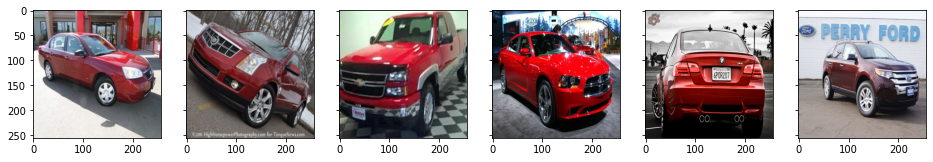

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = train_dataset[random_characters][0]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

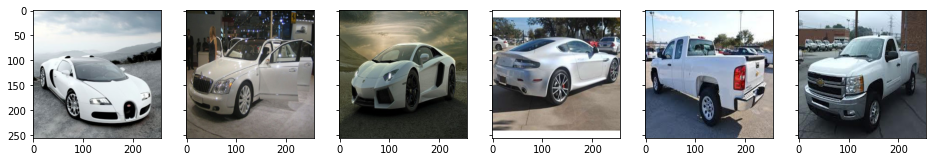

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = train_dataset[random_characters][1]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

In [ ]:
test_red = Path('/content/TestB')
test_white = Path('/content/TestA')

white_test_files = sorted(list(test_white.rglob('*.jpg')))
red_test_files = sorted(list(test_red.rglob('*.jpg')))
white_test = []
red_test = []
for filename in white_test_files:
  white_test.append(str(filename))

for filename in red_test_files:
  red_test.append(str(filename)) 

In [ ]:
test_dataset = Cars(red_test, white_test)

In [ ]:
train(train_dataset, test_dataset)